In [1]:
import os
import requests
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import PIL
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Destination folder of our images
download_path = "sketches_png.zip"
extracted_path = "sketches_png"

# Check if the folder is already downloaded
if not os.path.exists(extracted_path):
    # Define the URL and the download path
    url = "http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip"
    
    # Download the zip file
    response = requests.get(url)
    with open(download_path, 'wb') as file:
        file.write(response.content)
    
    # Extract the zip file
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
        
    print(f"Folder '{extracted_path}' downloaded.")
else:
    print(f"Folder '{extracted_path}' already downloaded.")

Folder 'sketches_png' already downloaded.


In [3]:
# Define transformations

norm_mean = 0
norm_stddev = 1

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize((norm_mean,), (norm_stddev,)),  # Normalize
])

In [4]:
#split data into train and test subset
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_TEST = 1000

root_path = extracted_path + "/png"
dataset = datasets.ImageFolder(root=root_path, transform=transform)

image_paths = [dataset.imgs[i][0] for i in range(len(dataset))]
labels = [dataset.imgs[i][1] for i in range(len(dataset))]
train_indices, test_indices = train_test_split(range(len(dataset)), test_size = 0.2, stratify=labels, random_state=42)
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [5]:
print(f"Len of whole dataset: {len(dataset)}")
print(f"Len of train dataset: {len(train_loader.dataset)}\nLen of test dataset: {len(test_loader.dataset)}")

Len of whole dataset: 20001
Len of train dataset: 16000
Len of test dataset: 4001


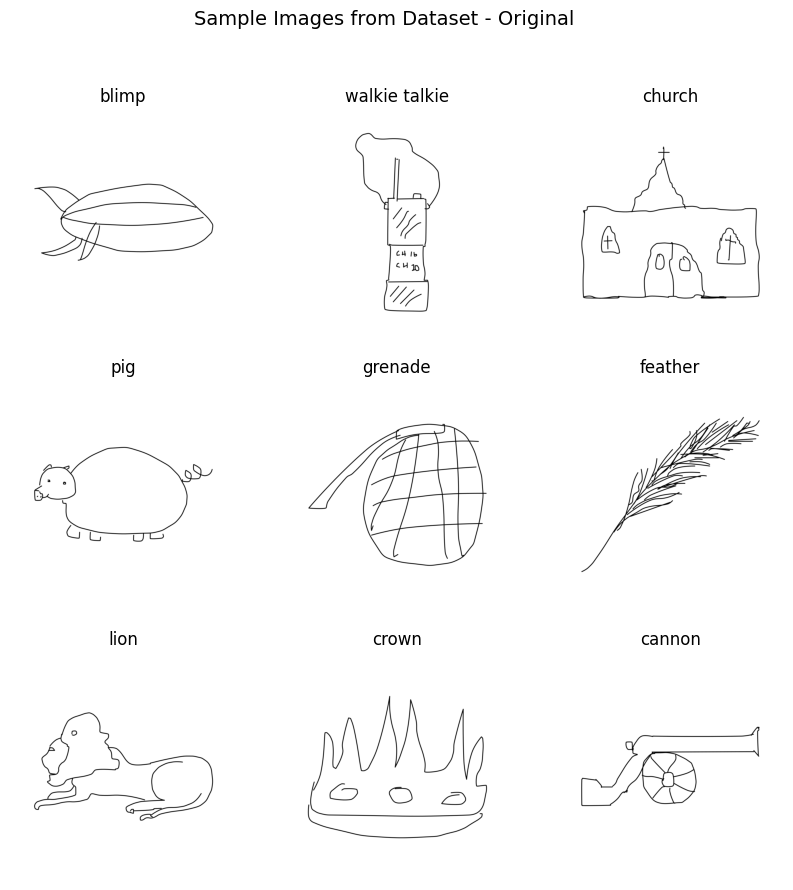

In [6]:
samples = random.sample(dataset.imgs, 9)

plt.figure(figsize=(10, 10))
i = 0
for image, label_idx in samples:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(image), cmap='gray')
    plt.title(dataset.classes[label_idx])
    plt.axis("off")
    i += 1
plt.suptitle('Sample Images from Dataset - Original', fontsize=14)
plt.show()

In [7]:
images, labels = next(iter(test_loader))

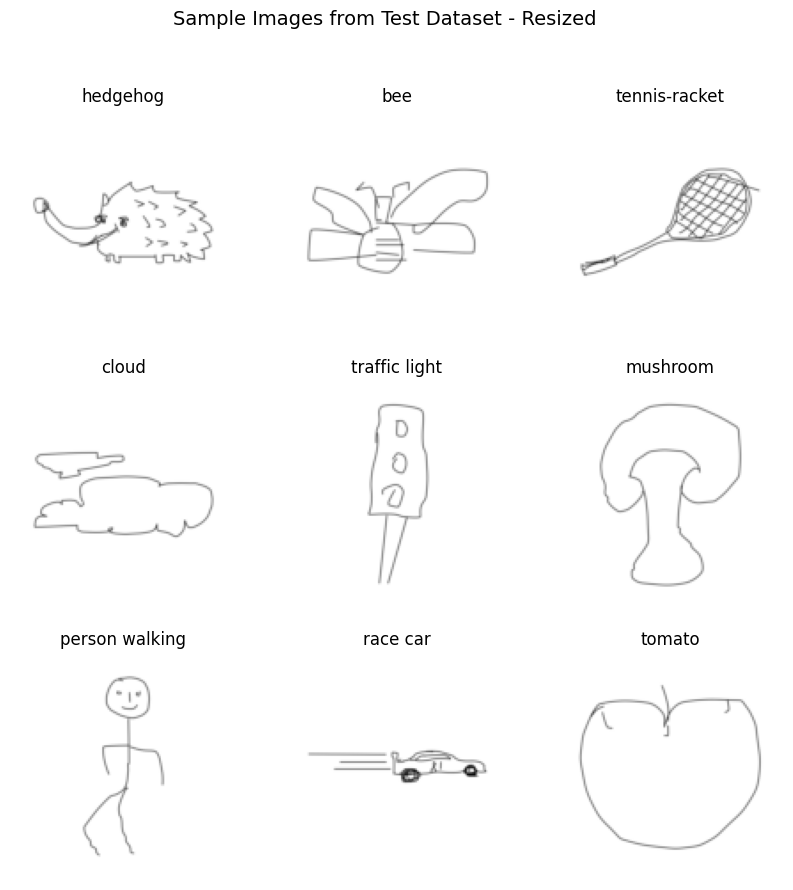

In [8]:
samples = list(zip(images, labels))
samples = random.sample(samples, 9)

mean = [norm_mean, norm_mean, norm_mean]  
std = [norm_stddev, norm_stddev, norm_stddev] 

plt.figure(figsize=(10, 10))
i = 0
for image, label in samples:
    ax = plt.subplot(3, 3, i + 1)
    
    img = image.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img, cmap='gray')
    plt.title(train_loader.dataset.dataset.classes[label.item()])
    plt.axis("off")
    i += 1
plt.suptitle('Sample Images from Test Dataset - Resized', fontsize=14)
plt.show()

In [9]:
for image, label in samples:
    print(image.shape)
    break

torch.Size([1, 128, 128])


In [10]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    return data.to(device, non_blocking=True)

In [11]:
print(get_device())

cpu


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class SketchClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes):
        super(SketchClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Calculate the size after conv2 + max_pool2d
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1

        size_after_conv1 = conv2d_size_out(image_size)
        size_after_conv2 = conv2d_size_out(size_after_conv1)
        size_after_pool = size_after_conv2 // 2  # After max_pool2d with kernel_size=2

        # Update the in_features of fc1
        self.fc1 = nn.Linear(size_after_pool * size_after_pool * 64, 128)
        self.fc2 = nn.Linear(128, number_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(input=x, kernel_size=2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

img_size = 128
number_of_classes = 250

In [19]:
img_size = 128
number_of_classes = 250

model = SketchClassifier(img_size, number_of_classes)
model = model.to(get_device())

In [20]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [21]:
count_parameters(model)

Layer: conv1, Parameters: 320
Layer: conv2, Parameters: 18496
Layer: dropout1, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: fc1, Parameters: 31490176
Layer: fc2, Parameters: 32250


31541242

In [22]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, multiclass=False):
  losses = []
  accuracies = []
  device = get_device()


  for epoch in range(number_of_epochs):
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          if multiclass:
            predicted = torch.argmax(outputs, dim=1)
          else:
            predicted = (outputs > 0.5).float()
          correct += (predicted.squeeze() == labels).sum().item()
          total += labels.size(0)

      epoch_loss = running_loss / len(train_loader)
      epoch_accuracy = correct / total
      losses.append(epoch_loss)
      accuracies.append(epoch_accuracy)
      print(f"Epoch [{epoch + 1}/{number_of_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

  return losses, accuracies

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

N_EPOCHS = 10

losses, accuracies = train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, multiclass=True)